# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

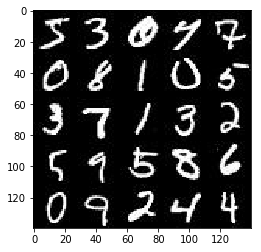

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

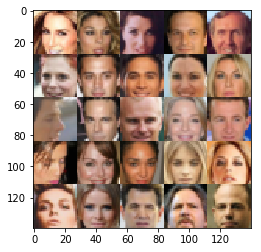

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


C:\Users\Pitto\Anaconda3\envs\tensorflow1_1\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels))
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())

    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        relu1 = tf.maximum(alpha * x1, x1)
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.2
        strt = 7
        st_filt = 512 
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding="SAME")
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding="SAME")
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    d_out_real,d_logits_real = discriminator(input_real, False)
    g_model = generator(input_z, out_channel_dim)
    d_out_fake,d_logits_fake = discriminator(g_model, True)
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_logits_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    b,x,y,c=data_shape
    input_real, input_z, _ = model_inputs(x, y, c, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, c)
    d_train_opt , g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            ii = 0
            for batch_images in get_batches(batch_size):
                ii = ii+1
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                if ii % 10 == 0 : 
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    
                if ii % 100 == 0 : 
                    show_generator_output(sess, 25, input_z, c, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8894... Generator Loss: 1.1794
Epoch 1/2... Discriminator Loss: 0.8654... Generator Loss: 1.0394
Epoch 1/2... Discriminator Loss: 1.0406... Generator Loss: 1.2816
Epoch 1/2... Discriminator Loss: 1.3446... Generator Loss: 0.7105
Epoch 1/2... Discriminator Loss: 0.7838... Generator Loss: 1.6750
Epoch 1/2... Discriminator Loss: 1.3096... Generator Loss: 0.7440
Epoch 1/2... Discriminator Loss: 1.7457... Generator Loss: 0.3273
Epoch 1/2... Discriminator Loss: 1.0169... Generator Loss: 1.9746
Epoch 1/2... Discriminator Loss: 1.2128... Generator Loss: 0.7180
Epoch 1/2... Discriminator Loss: 1.4593... Generator Loss: 0.4751


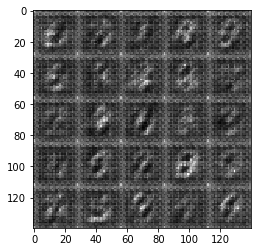

Epoch 1/2... Discriminator Loss: 1.2198... Generator Loss: 1.6524
Epoch 1/2... Discriminator Loss: 1.0507... Generator Loss: 1.1728
Epoch 1/2... Discriminator Loss: 0.9874... Generator Loss: 1.5151
Epoch 1/2... Discriminator Loss: 1.0128... Generator Loss: 1.5595
Epoch 1/2... Discriminator Loss: 1.0284... Generator Loss: 1.1571
Epoch 1/2... Discriminator Loss: 1.6181... Generator Loss: 0.3995
Epoch 1/2... Discriminator Loss: 1.6865... Generator Loss: 0.3758
Epoch 1/2... Discriminator Loss: 1.1065... Generator Loss: 0.7244
Epoch 1/2... Discriminator Loss: 1.0078... Generator Loss: 0.9153
Epoch 1/2... Discriminator Loss: 1.9032... Generator Loss: 0.2691


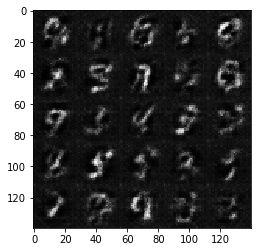

Epoch 1/2... Discriminator Loss: 1.3599... Generator Loss: 0.6103
Epoch 1/2... Discriminator Loss: 0.8299... Generator Loss: 1.3591
Epoch 1/2... Discriminator Loss: 0.9128... Generator Loss: 1.1068
Epoch 1/2... Discriminator Loss: 0.9615... Generator Loss: 0.9876
Epoch 1/2... Discriminator Loss: 0.9610... Generator Loss: 1.3023
Epoch 1/2... Discriminator Loss: 0.7927... Generator Loss: 1.6280
Epoch 1/2... Discriminator Loss: 0.9464... Generator Loss: 2.0590
Epoch 1/2... Discriminator Loss: 1.0576... Generator Loss: 0.7481
Epoch 1/2... Discriminator Loss: 1.0275... Generator Loss: 1.5866
Epoch 1/2... Discriminator Loss: 1.1243... Generator Loss: 0.7378


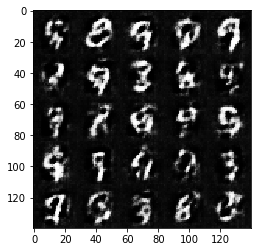

Epoch 1/2... Discriminator Loss: 0.8555... Generator Loss: 1.0826
Epoch 1/2... Discriminator Loss: 0.7268... Generator Loss: 1.4988
Epoch 1/2... Discriminator Loss: 0.9231... Generator Loss: 1.1419
Epoch 1/2... Discriminator Loss: 1.0866... Generator Loss: 0.8067
Epoch 1/2... Discriminator Loss: 0.7542... Generator Loss: 1.6825
Epoch 1/2... Discriminator Loss: 0.8934... Generator Loss: 1.1659
Epoch 1/2... Discriminator Loss: 0.7992... Generator Loss: 1.7126
Epoch 1/2... Discriminator Loss: 1.0291... Generator Loss: 0.8592
Epoch 1/2... Discriminator Loss: 0.6858... Generator Loss: 1.8060
Epoch 1/2... Discriminator Loss: 0.9111... Generator Loss: 1.0447


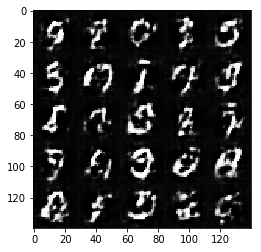

Epoch 1/2... Discriminator Loss: 1.7627... Generator Loss: 0.3498
Epoch 1/2... Discriminator Loss: 0.9292... Generator Loss: 0.9815
Epoch 1/2... Discriminator Loss: 1.1611... Generator Loss: 0.6653
Epoch 1/2... Discriminator Loss: 1.0126... Generator Loss: 0.9092
Epoch 1/2... Discriminator Loss: 0.8157... Generator Loss: 1.8925
Epoch 1/2... Discriminator Loss: 0.9656... Generator Loss: 1.1309
Epoch 1/2... Discriminator Loss: 0.9245... Generator Loss: 1.1407
Epoch 1/2... Discriminator Loss: 1.2174... Generator Loss: 2.1627
Epoch 1/2... Discriminator Loss: 0.9102... Generator Loss: 1.9028
Epoch 1/2... Discriminator Loss: 0.8970... Generator Loss: 1.0796


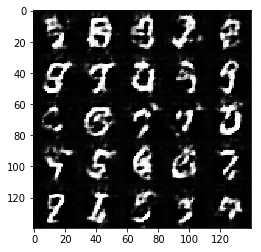

Epoch 1/2... Discriminator Loss: 0.8507... Generator Loss: 1.6832
Epoch 1/2... Discriminator Loss: 0.8360... Generator Loss: 1.6164
Epoch 1/2... Discriminator Loss: 0.8798... Generator Loss: 2.2417
Epoch 1/2... Discriminator Loss: 1.4112... Generator Loss: 0.5773
Epoch 1/2... Discriminator Loss: 0.8497... Generator Loss: 1.7023
Epoch 1/2... Discriminator Loss: 1.4191... Generator Loss: 2.9382
Epoch 1/2... Discriminator Loss: 0.8715... Generator Loss: 1.4860
Epoch 1/2... Discriminator Loss: 1.2442... Generator Loss: 2.0220
Epoch 1/2... Discriminator Loss: 1.0913... Generator Loss: 2.1345
Epoch 1/2... Discriminator Loss: 1.1360... Generator Loss: 0.7147


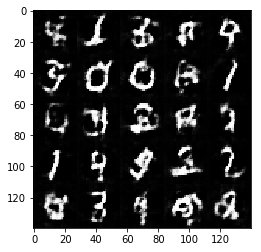

Epoch 1/2... Discriminator Loss: 0.9856... Generator Loss: 1.0208
Epoch 1/2... Discriminator Loss: 1.0688... Generator Loss: 0.8228
Epoch 1/2... Discriminator Loss: 0.9737... Generator Loss: 1.1250
Epoch 1/2... Discriminator Loss: 1.0011... Generator Loss: 1.0852
Epoch 1/2... Discriminator Loss: 1.1739... Generator Loss: 0.6661
Epoch 1/2... Discriminator Loss: 0.9460... Generator Loss: 1.0251
Epoch 1/2... Discriminator Loss: 1.4416... Generator Loss: 2.4490
Epoch 1/2... Discriminator Loss: 0.8629... Generator Loss: 1.3751
Epoch 1/2... Discriminator Loss: 1.5673... Generator Loss: 0.4320
Epoch 1/2... Discriminator Loss: 0.9575... Generator Loss: 1.0956


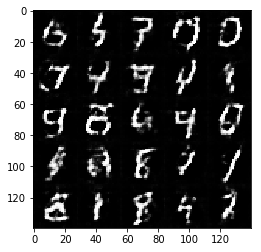

Epoch 1/2... Discriminator Loss: 1.7162... Generator Loss: 0.3421
Epoch 1/2... Discriminator Loss: 1.0403... Generator Loss: 1.2274
Epoch 1/2... Discriminator Loss: 0.9362... Generator Loss: 1.2122
Epoch 1/2... Discriminator Loss: 1.5815... Generator Loss: 0.3963
Epoch 1/2... Discriminator Loss: 1.0952... Generator Loss: 0.7712
Epoch 1/2... Discriminator Loss: 0.7399... Generator Loss: 1.6194
Epoch 1/2... Discriminator Loss: 1.0843... Generator Loss: 0.8712
Epoch 1/2... Discriminator Loss: 0.9452... Generator Loss: 1.2122
Epoch 1/2... Discriminator Loss: 0.9451... Generator Loss: 0.9779
Epoch 1/2... Discriminator Loss: 2.0140... Generator Loss: 0.2832


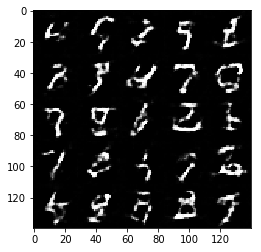

Epoch 1/2... Discriminator Loss: 0.8186... Generator Loss: 1.4139
Epoch 1/2... Discriminator Loss: 1.3189... Generator Loss: 0.5821
Epoch 1/2... Discriminator Loss: 1.3501... Generator Loss: 0.5318
Epoch 1/2... Discriminator Loss: 0.9236... Generator Loss: 1.5450
Epoch 1/2... Discriminator Loss: 0.9729... Generator Loss: 0.9451
Epoch 1/2... Discriminator Loss: 1.1321... Generator Loss: 0.7715
Epoch 1/2... Discriminator Loss: 0.9734... Generator Loss: 1.2498
Epoch 1/2... Discriminator Loss: 1.2890... Generator Loss: 0.5753
Epoch 1/2... Discriminator Loss: 0.9361... Generator Loss: 1.0206
Epoch 1/2... Discriminator Loss: 0.8989... Generator Loss: 1.1751


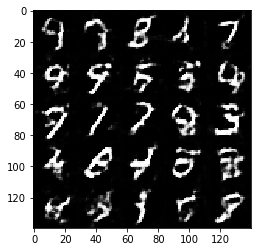

Epoch 1/2... Discriminator Loss: 0.8980... Generator Loss: 1.2201
Epoch 1/2... Discriminator Loss: 0.9672... Generator Loss: 1.8847
Epoch 1/2... Discriminator Loss: 1.0805... Generator Loss: 0.8574
Epoch 1/2... Discriminator Loss: 1.4164... Generator Loss: 0.4837
Epoch 1/2... Discriminator Loss: 1.2819... Generator Loss: 1.9939
Epoch 1/2... Discriminator Loss: 0.8208... Generator Loss: 2.0015
Epoch 1/2... Discriminator Loss: 1.1018... Generator Loss: 1.1806
Epoch 1/2... Discriminator Loss: 1.0436... Generator Loss: 1.8778
Epoch 1/2... Discriminator Loss: 0.9897... Generator Loss: 1.1078
Epoch 1/2... Discriminator Loss: 1.5721... Generator Loss: 0.4310


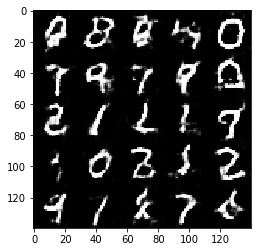

Epoch 1/2... Discriminator Loss: 1.0733... Generator Loss: 0.8522
Epoch 1/2... Discriminator Loss: 1.0427... Generator Loss: 0.9065
Epoch 1/2... Discriminator Loss: 0.8758... Generator Loss: 1.5118
Epoch 1/2... Discriminator Loss: 1.1713... Generator Loss: 0.7961
Epoch 1/2... Discriminator Loss: 0.9205... Generator Loss: 1.3741
Epoch 1/2... Discriminator Loss: 0.8594... Generator Loss: 1.4710
Epoch 1/2... Discriminator Loss: 0.8531... Generator Loss: 1.2762
Epoch 1/2... Discriminator Loss: 0.9633... Generator Loss: 1.3705
Epoch 1/2... Discriminator Loss: 1.0879... Generator Loss: 0.8237
Epoch 1/2... Discriminator Loss: 1.0294... Generator Loss: 1.6639


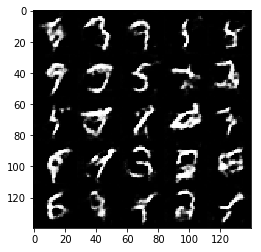

Epoch 1/2... Discriminator Loss: 1.4607... Generator Loss: 0.5432
Epoch 1/2... Discriminator Loss: 0.8875... Generator Loss: 1.2128
Epoch 1/2... Discriminator Loss: 1.3281... Generator Loss: 0.5649
Epoch 1/2... Discriminator Loss: 1.3532... Generator Loss: 0.9340
Epoch 1/2... Discriminator Loss: 0.9527... Generator Loss: 1.2436
Epoch 1/2... Discriminator Loss: 0.9772... Generator Loss: 1.4394
Epoch 1/2... Discriminator Loss: 0.9653... Generator Loss: 1.5643
Epoch 1/2... Discriminator Loss: 0.8248... Generator Loss: 1.4536
Epoch 1/2... Discriminator Loss: 0.9985... Generator Loss: 0.8723
Epoch 1/2... Discriminator Loss: 0.8369... Generator Loss: 1.4272


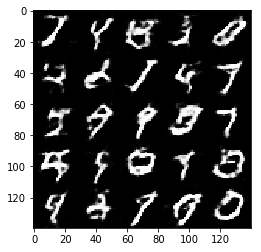

Epoch 1/2... Discriminator Loss: 0.9250... Generator Loss: 1.1344
Epoch 1/2... Discriminator Loss: 0.9082... Generator Loss: 1.3511
Epoch 1/2... Discriminator Loss: 1.0393... Generator Loss: 1.2555
Epoch 1/2... Discriminator Loss: 0.9977... Generator Loss: 1.1022
Epoch 1/2... Discriminator Loss: 1.0915... Generator Loss: 0.8923
Epoch 1/2... Discriminator Loss: 1.1041... Generator Loss: 0.7651
Epoch 1/2... Discriminator Loss: 1.0874... Generator Loss: 0.7516
Epoch 1/2... Discriminator Loss: 0.8270... Generator Loss: 1.3221
Epoch 1/2... Discriminator Loss: 0.9658... Generator Loss: 1.2298
Epoch 1/2... Discriminator Loss: 1.2050... Generator Loss: 0.7405


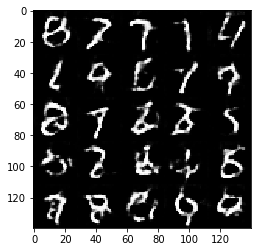

Epoch 1/2... Discriminator Loss: 0.8604... Generator Loss: 1.2140
Epoch 1/2... Discriminator Loss: 1.3057... Generator Loss: 0.6402
Epoch 1/2... Discriminator Loss: 1.0966... Generator Loss: 0.8148
Epoch 1/2... Discriminator Loss: 0.8720... Generator Loss: 1.8084
Epoch 1/2... Discriminator Loss: 1.0219... Generator Loss: 1.0196
Epoch 1/2... Discriminator Loss: 1.5098... Generator Loss: 0.4480
Epoch 1/2... Discriminator Loss: 0.7983... Generator Loss: 1.3310
Epoch 1/2... Discriminator Loss: 0.8434... Generator Loss: 1.9071
Epoch 1/2... Discriminator Loss: 0.9827... Generator Loss: 1.8104
Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 0.7442


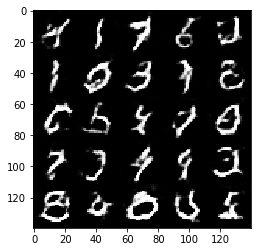

Epoch 1/2... Discriminator Loss: 1.0162... Generator Loss: 1.0940
Epoch 1/2... Discriminator Loss: 0.8039... Generator Loss: 1.2975
Epoch 1/2... Discriminator Loss: 1.4553... Generator Loss: 2.6297
Epoch 1/2... Discriminator Loss: 1.1105... Generator Loss: 0.8132
Epoch 1/2... Discriminator Loss: 1.0676... Generator Loss: 0.7733
Epoch 1/2... Discriminator Loss: 0.8760... Generator Loss: 1.4093
Epoch 1/2... Discriminator Loss: 1.1822... Generator Loss: 0.7206
Epoch 1/2... Discriminator Loss: 0.8094... Generator Loss: 1.9916
Epoch 1/2... Discriminator Loss: 0.9231... Generator Loss: 1.1529
Epoch 1/2... Discriminator Loss: 0.7808... Generator Loss: 1.8078


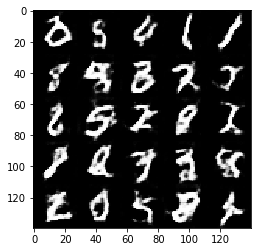

Epoch 1/2... Discriminator Loss: 1.2005... Generator Loss: 0.6221
Epoch 1/2... Discriminator Loss: 0.6889... Generator Loss: 1.5079
Epoch 1/2... Discriminator Loss: 1.0945... Generator Loss: 0.7471
Epoch 1/2... Discriminator Loss: 0.7323... Generator Loss: 1.5356
Epoch 1/2... Discriminator Loss: 1.6011... Generator Loss: 0.4273
Epoch 1/2... Discriminator Loss: 1.2350... Generator Loss: 1.7756
Epoch 1/2... Discriminator Loss: 1.0031... Generator Loss: 1.8206
Epoch 1/2... Discriminator Loss: 0.8229... Generator Loss: 1.3060
Epoch 1/2... Discriminator Loss: 1.2902... Generator Loss: 2.0805
Epoch 1/2... Discriminator Loss: 1.3344... Generator Loss: 0.5629


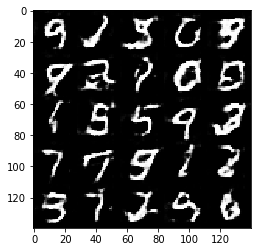

Epoch 1/2... Discriminator Loss: 1.0180... Generator Loss: 2.1671
Epoch 1/2... Discriminator Loss: 0.9506... Generator Loss: 0.9036
Epoch 1/2... Discriminator Loss: 0.8036... Generator Loss: 1.2538
Epoch 1/2... Discriminator Loss: 1.3448... Generator Loss: 0.5748
Epoch 1/2... Discriminator Loss: 0.7295... Generator Loss: 1.8176
Epoch 1/2... Discriminator Loss: 0.6878... Generator Loss: 1.5814
Epoch 1/2... Discriminator Loss: 0.9819... Generator Loss: 1.0188
Epoch 1/2... Discriminator Loss: 0.8213... Generator Loss: 1.1145
Epoch 1/2... Discriminator Loss: 1.2070... Generator Loss: 0.7396
Epoch 1/2... Discriminator Loss: 0.6262... Generator Loss: 1.7882


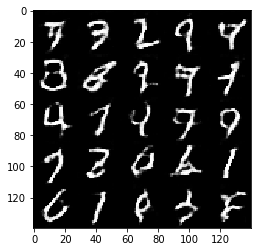

Epoch 1/2... Discriminator Loss: 0.8608... Generator Loss: 1.0154
Epoch 1/2... Discriminator Loss: 0.9186... Generator Loss: 1.2196
Epoch 1/2... Discriminator Loss: 0.9978... Generator Loss: 1.9774
Epoch 1/2... Discriminator Loss: 0.8350... Generator Loss: 1.4122
Epoch 1/2... Discriminator Loss: 0.7458... Generator Loss: 1.7941
Epoch 1/2... Discriminator Loss: 1.4465... Generator Loss: 0.4921
Epoch 1/2... Discriminator Loss: 0.7290... Generator Loss: 1.4095
Epoch 1/2... Discriminator Loss: 0.6977... Generator Loss: 1.4658
Epoch 1/2... Discriminator Loss: 0.8227... Generator Loss: 1.2420
Epoch 1/2... Discriminator Loss: 0.6449... Generator Loss: 1.7777


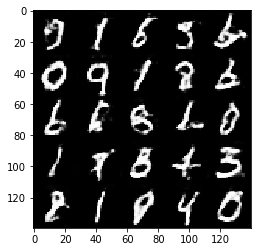

Epoch 1/2... Discriminator Loss: 0.7994... Generator Loss: 1.3622
Epoch 1/2... Discriminator Loss: 1.3033... Generator Loss: 0.5798
Epoch 1/2... Discriminator Loss: 1.4279... Generator Loss: 3.6197
Epoch 1/2... Discriminator Loss: 0.8312... Generator Loss: 1.4547
Epoch 1/2... Discriminator Loss: 1.0184... Generator Loss: 0.8754
Epoch 1/2... Discriminator Loss: 1.2444... Generator Loss: 0.6097
Epoch 1/2... Discriminator Loss: 0.8511... Generator Loss: 1.1846
Epoch 2/2... Discriminator Loss: 0.6762... Generator Loss: 1.4860
Epoch 2/2... Discriminator Loss: 0.9423... Generator Loss: 1.5849
Epoch 2/2... Discriminator Loss: 0.8221... Generator Loss: 1.1877
Epoch 2/2... Discriminator Loss: 0.8808... Generator Loss: 1.1084
Epoch 2/2... Discriminator Loss: 0.9703... Generator Loss: 0.9485
Epoch 2/2... Discriminator Loss: 1.1039... Generator Loss: 0.7965
Epoch 2/2... Discriminator Loss: 1.1348... Generator Loss: 0.8125
Epoch 2/2... Discriminator Loss: 0.7541... Generator Loss: 1.4380
Epoch 2/2.

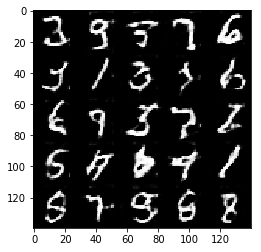

Epoch 2/2... Discriminator Loss: 2.1365... Generator Loss: 0.3343
Epoch 2/2... Discriminator Loss: 0.7317... Generator Loss: 1.4446
Epoch 2/2... Discriminator Loss: 1.1116... Generator Loss: 0.8343
Epoch 2/2... Discriminator Loss: 1.2274... Generator Loss: 0.6160
Epoch 2/2... Discriminator Loss: 0.9001... Generator Loss: 1.0912
Epoch 2/2... Discriminator Loss: 0.7778... Generator Loss: 1.9636
Epoch 2/2... Discriminator Loss: 1.6040... Generator Loss: 0.4036
Epoch 2/2... Discriminator Loss: 0.7373... Generator Loss: 1.3428
Epoch 2/2... Discriminator Loss: 1.0066... Generator Loss: 0.8199
Epoch 2/2... Discriminator Loss: 0.9094... Generator Loss: 1.0153


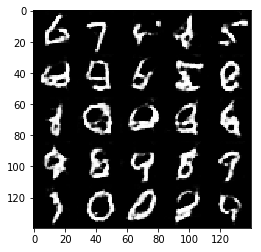

Epoch 2/2... Discriminator Loss: 1.5760... Generator Loss: 0.4608
Epoch 2/2... Discriminator Loss: 0.7000... Generator Loss: 1.6883
Epoch 2/2... Discriminator Loss: 0.7373... Generator Loss: 1.3707
Epoch 2/2... Discriminator Loss: 0.9686... Generator Loss: 0.8935
Epoch 2/2... Discriminator Loss: 0.8780... Generator Loss: 1.0658
Epoch 2/2... Discriminator Loss: 0.6261... Generator Loss: 1.7551
Epoch 2/2... Discriminator Loss: 0.8220... Generator Loss: 1.2290
Epoch 2/2... Discriminator Loss: 0.8202... Generator Loss: 1.4364
Epoch 2/2... Discriminator Loss: 1.1699... Generator Loss: 2.5088
Epoch 2/2... Discriminator Loss: 0.9323... Generator Loss: 1.1147


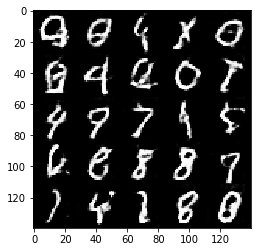

Epoch 2/2... Discriminator Loss: 0.6991... Generator Loss: 1.5559
Epoch 2/2... Discriminator Loss: 1.4048... Generator Loss: 0.5301
Epoch 2/2... Discriminator Loss: 0.7365... Generator Loss: 1.3808
Epoch 2/2... Discriminator Loss: 0.7950... Generator Loss: 1.2115
Epoch 2/2... Discriminator Loss: 0.8672... Generator Loss: 1.0668
Epoch 2/2... Discriminator Loss: 1.2159... Generator Loss: 0.6791
Epoch 2/2... Discriminator Loss: 1.0186... Generator Loss: 0.8418
Epoch 2/2... Discriminator Loss: 1.1896... Generator Loss: 0.6916
Epoch 2/2... Discriminator Loss: 0.9441... Generator Loss: 0.9848
Epoch 2/2... Discriminator Loss: 0.7603... Generator Loss: 1.2534


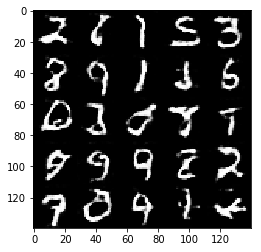

Epoch 2/2... Discriminator Loss: 2.0544... Generator Loss: 0.2797
Epoch 2/2... Discriminator Loss: 0.8011... Generator Loss: 1.2619
Epoch 2/2... Discriminator Loss: 0.8800... Generator Loss: 1.1702
Epoch 2/2... Discriminator Loss: 1.1751... Generator Loss: 0.7424
Epoch 2/2... Discriminator Loss: 0.6941... Generator Loss: 1.7166
Epoch 2/2... Discriminator Loss: 0.8793... Generator Loss: 1.8741
Epoch 2/2... Discriminator Loss: 0.8546... Generator Loss: 1.1536
Epoch 2/2... Discriminator Loss: 0.9293... Generator Loss: 0.9992
Epoch 2/2... Discriminator Loss: 0.8619... Generator Loss: 1.0540
Epoch 2/2... Discriminator Loss: 0.8409... Generator Loss: 1.0849


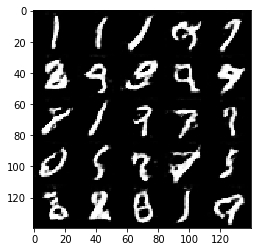

Epoch 2/2... Discriminator Loss: 0.7627... Generator Loss: 1.3215
Epoch 2/2... Discriminator Loss: 0.7925... Generator Loss: 1.3717
Epoch 2/2... Discriminator Loss: 1.0429... Generator Loss: 0.7731
Epoch 2/2... Discriminator Loss: 1.7384... Generator Loss: 0.4659
Epoch 2/2... Discriminator Loss: 0.7740... Generator Loss: 1.2954
Epoch 2/2... Discriminator Loss: 1.1178... Generator Loss: 1.9865
Epoch 2/2... Discriminator Loss: 0.7363... Generator Loss: 1.6075
Epoch 2/2... Discriminator Loss: 0.8048... Generator Loss: 1.1773
Epoch 2/2... Discriminator Loss: 0.6476... Generator Loss: 1.9018
Epoch 2/2... Discriminator Loss: 0.8949... Generator Loss: 1.1018


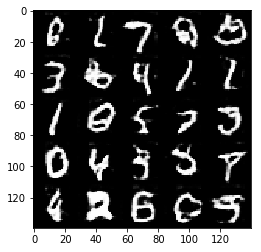

Epoch 2/2... Discriminator Loss: 0.9400... Generator Loss: 0.9622
Epoch 2/2... Discriminator Loss: 0.9220... Generator Loss: 1.0371
Epoch 2/2... Discriminator Loss: 0.7280... Generator Loss: 1.4572
Epoch 2/2... Discriminator Loss: 0.7665... Generator Loss: 1.3365
Epoch 2/2... Discriminator Loss: 0.7159... Generator Loss: 1.9268
Epoch 2/2... Discriminator Loss: 0.7368... Generator Loss: 1.2572
Epoch 2/2... Discriminator Loss: 0.8369... Generator Loss: 1.2080
Epoch 2/2... Discriminator Loss: 0.8280... Generator Loss: 1.2528
Epoch 2/2... Discriminator Loss: 1.0854... Generator Loss: 0.8654
Epoch 2/2... Discriminator Loss: 0.7394... Generator Loss: 1.4151


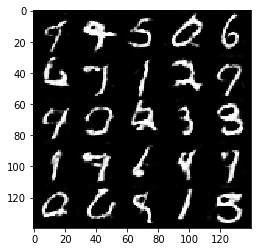

Epoch 2/2... Discriminator Loss: 0.8546... Generator Loss: 1.2843
Epoch 2/2... Discriminator Loss: 0.8780... Generator Loss: 1.1450
Epoch 2/2... Discriminator Loss: 0.7043... Generator Loss: 1.7188
Epoch 2/2... Discriminator Loss: 0.7748... Generator Loss: 1.3194
Epoch 2/2... Discriminator Loss: 0.7015... Generator Loss: 1.9682
Epoch 2/2... Discriminator Loss: 0.7064... Generator Loss: 1.4121
Epoch 2/2... Discriminator Loss: 1.1977... Generator Loss: 3.6952
Epoch 2/2... Discriminator Loss: 0.7897... Generator Loss: 1.5930
Epoch 2/2... Discriminator Loss: 1.2946... Generator Loss: 0.6665
Epoch 2/2... Discriminator Loss: 1.0636... Generator Loss: 0.7893


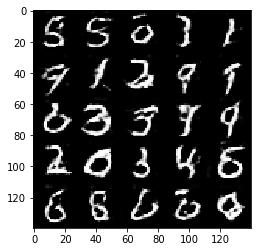

Epoch 2/2... Discriminator Loss: 0.8599... Generator Loss: 1.8701
Epoch 2/2... Discriminator Loss: 0.9105... Generator Loss: 1.0577
Epoch 2/2... Discriminator Loss: 2.7340... Generator Loss: 0.1978
Epoch 2/2... Discriminator Loss: 0.6261... Generator Loss: 1.6952
Epoch 2/2... Discriminator Loss: 0.7774... Generator Loss: 1.3451
Epoch 2/2... Discriminator Loss: 0.7917... Generator Loss: 2.1354
Epoch 2/2... Discriminator Loss: 1.2407... Generator Loss: 0.6072
Epoch 2/2... Discriminator Loss: 1.3120... Generator Loss: 0.6042
Epoch 2/2... Discriminator Loss: 0.8782... Generator Loss: 1.0151
Epoch 2/2... Discriminator Loss: 0.7119... Generator Loss: 1.4180


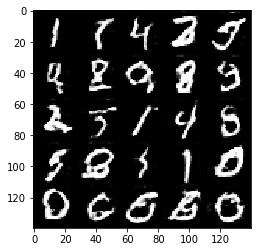

Epoch 2/2... Discriminator Loss: 0.8279... Generator Loss: 2.2092
Epoch 2/2... Discriminator Loss: 0.7308... Generator Loss: 1.4782
Epoch 2/2... Discriminator Loss: 0.8632... Generator Loss: 1.2971
Epoch 2/2... Discriminator Loss: 1.1018... Generator Loss: 0.7732
Epoch 2/2... Discriminator Loss: 0.6193... Generator Loss: 1.9962
Epoch 2/2... Discriminator Loss: 0.7166... Generator Loss: 1.4719
Epoch 2/2... Discriminator Loss: 0.8846... Generator Loss: 2.2265
Epoch 2/2... Discriminator Loss: 0.6596... Generator Loss: 2.2716
Epoch 2/2... Discriminator Loss: 1.2772... Generator Loss: 0.6322
Epoch 2/2... Discriminator Loss: 0.8575... Generator Loss: 1.1033


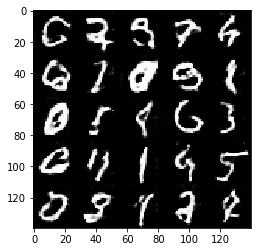

Epoch 2/2... Discriminator Loss: 1.1656... Generator Loss: 0.6997
Epoch 2/2... Discriminator Loss: 3.4386... Generator Loss: 0.1331
Epoch 2/2... Discriminator Loss: 0.9928... Generator Loss: 0.8940
Epoch 2/2... Discriminator Loss: 0.9454... Generator Loss: 0.9146
Epoch 2/2... Discriminator Loss: 0.6389... Generator Loss: 1.7377
Epoch 2/2... Discriminator Loss: 0.8706... Generator Loss: 1.2102
Epoch 2/2... Discriminator Loss: 0.6329... Generator Loss: 1.5590
Epoch 2/2... Discriminator Loss: 0.8232... Generator Loss: 1.1341
Epoch 2/2... Discriminator Loss: 0.7420... Generator Loss: 1.3159
Epoch 2/2... Discriminator Loss: 0.8554... Generator Loss: 1.0991


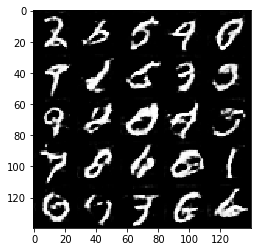

Epoch 2/2... Discriminator Loss: 2.8728... Generator Loss: 0.2352
Epoch 2/2... Discriminator Loss: 0.7864... Generator Loss: 2.1374
Epoch 2/2... Discriminator Loss: 0.7595... Generator Loss: 1.4160
Epoch 2/2... Discriminator Loss: 0.8175... Generator Loss: 1.3402
Epoch 2/2... Discriminator Loss: 0.8612... Generator Loss: 1.0726
Epoch 2/2... Discriminator Loss: 0.7386... Generator Loss: 1.3252
Epoch 2/2... Discriminator Loss: 1.1834... Generator Loss: 0.6841
Epoch 2/2... Discriminator Loss: 0.8028... Generator Loss: 1.1207
Epoch 2/2... Discriminator Loss: 0.6878... Generator Loss: 1.7725
Epoch 2/2... Discriminator Loss: 1.0159... Generator Loss: 0.8728


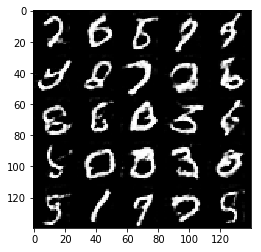

Epoch 2/2... Discriminator Loss: 0.7279... Generator Loss: 1.5751
Epoch 2/2... Discriminator Loss: 0.9800... Generator Loss: 1.0534
Epoch 2/2... Discriminator Loss: 0.8716... Generator Loss: 1.1286
Epoch 2/2... Discriminator Loss: 0.7485... Generator Loss: 1.3290
Epoch 2/2... Discriminator Loss: 0.6741... Generator Loss: 1.7114
Epoch 2/2... Discriminator Loss: 0.7729... Generator Loss: 1.6109
Epoch 2/2... Discriminator Loss: 1.4359... Generator Loss: 0.5618
Epoch 2/2... Discriminator Loss: 0.5630... Generator Loss: 1.8954
Epoch 2/2... Discriminator Loss: 1.1683... Generator Loss: 0.6834
Epoch 2/2... Discriminator Loss: 1.0435... Generator Loss: 0.9970


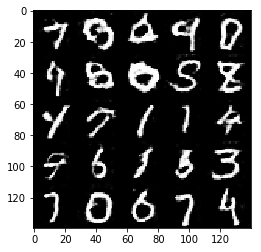

Epoch 2/2... Discriminator Loss: 0.6514... Generator Loss: 1.8545
Epoch 2/2... Discriminator Loss: 1.6487... Generator Loss: 0.4208
Epoch 2/2... Discriminator Loss: 0.7639... Generator Loss: 1.2816
Epoch 2/2... Discriminator Loss: 0.6700... Generator Loss: 1.8558
Epoch 2/2... Discriminator Loss: 0.8035... Generator Loss: 1.2234
Epoch 2/2... Discriminator Loss: 1.2670... Generator Loss: 0.8494
Epoch 2/2... Discriminator Loss: 0.7963... Generator Loss: 1.3193
Epoch 2/2... Discriminator Loss: 0.7015... Generator Loss: 1.4455
Epoch 2/2... Discriminator Loss: 0.8534... Generator Loss: 1.1139
Epoch 2/2... Discriminator Loss: 0.8100... Generator Loss: 1.3096


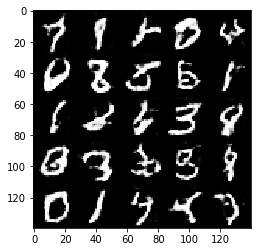

Epoch 2/2... Discriminator Loss: 0.6474... Generator Loss: 2.1556
Epoch 2/2... Discriminator Loss: 0.9230... Generator Loss: 1.1071
Epoch 2/2... Discriminator Loss: 3.0421... Generator Loss: 4.8928
Epoch 2/2... Discriminator Loss: 1.2499... Generator Loss: 1.1554
Epoch 2/2... Discriminator Loss: 0.8823... Generator Loss: 1.2084
Epoch 2/2... Discriminator Loss: 0.7229... Generator Loss: 1.4167
Epoch 2/2... Discriminator Loss: 1.0807... Generator Loss: 0.8170
Epoch 2/2... Discriminator Loss: 0.7110... Generator Loss: 1.3894
Epoch 2/2... Discriminator Loss: 0.7999... Generator Loss: 1.4904
Epoch 2/2... Discriminator Loss: 0.6619... Generator Loss: 2.0754


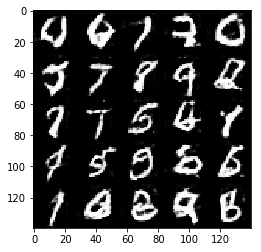

Epoch 2/2... Discriminator Loss: 1.1400... Generator Loss: 0.7776
Epoch 2/2... Discriminator Loss: 0.7913... Generator Loss: 1.2578
Epoch 2/2... Discriminator Loss: 0.7222... Generator Loss: 1.5439
Epoch 2/2... Discriminator Loss: 0.6528... Generator Loss: 1.7684
Epoch 2/2... Discriminator Loss: 0.8400... Generator Loss: 1.2700
Epoch 2/2... Discriminator Loss: 0.7433... Generator Loss: 1.3290
Epoch 2/2... Discriminator Loss: 0.7542... Generator Loss: 1.3883
Epoch 2/2... Discriminator Loss: 0.9104... Generator Loss: 1.0393
Epoch 2/2... Discriminator Loss: 0.8625... Generator Loss: 1.1662
Epoch 2/2... Discriminator Loss: 0.9696... Generator Loss: 0.9351


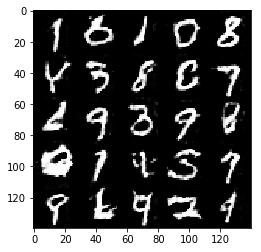

Epoch 2/2... Discriminator Loss: 0.8234... Generator Loss: 1.7606
Epoch 2/2... Discriminator Loss: 0.8760... Generator Loss: 1.1680
Epoch 2/2... Discriminator Loss: 0.7210... Generator Loss: 1.3984
Epoch 2/2... Discriminator Loss: 0.8053... Generator Loss: 1.2069
Epoch 2/2... Discriminator Loss: 0.6442... Generator Loss: 1.6686
Epoch 2/2... Discriminator Loss: 0.6141... Generator Loss: 1.6574
Epoch 2/2... Discriminator Loss: 1.0680... Generator Loss: 0.8567
Epoch 2/2... Discriminator Loss: 0.5595... Generator Loss: 2.1013
Epoch 2/2... Discriminator Loss: 0.6603... Generator Loss: 1.6602
Epoch 2/2... Discriminator Loss: 0.6321... Generator Loss: 1.7847


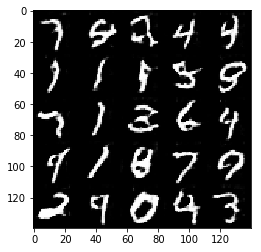

Epoch 2/2... Discriminator Loss: 0.5602... Generator Loss: 1.9261
Epoch 2/2... Discriminator Loss: 0.7095... Generator Loss: 1.6791
Epoch 2/2... Discriminator Loss: 0.8813... Generator Loss: 1.2612
Epoch 2/2... Discriminator Loss: 1.0069... Generator Loss: 1.2920
Epoch 2/2... Discriminator Loss: 0.6820... Generator Loss: 1.5285
Epoch 2/2... Discriminator Loss: 1.2014... Generator Loss: 0.7370
Epoch 2/2... Discriminator Loss: 0.7262... Generator Loss: 1.4200
Epoch 2/2... Discriminator Loss: 0.7197... Generator Loss: 1.5891
Epoch 2/2... Discriminator Loss: 0.8257... Generator Loss: 1.2289
Epoch 2/2... Discriminator Loss: 0.5965... Generator Loss: 1.8246


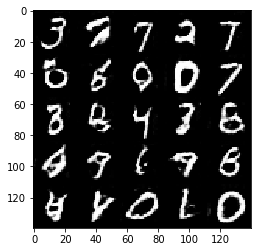

Epoch 2/2... Discriminator Loss: 0.7498... Generator Loss: 1.3367
Epoch 2/2... Discriminator Loss: 0.7086... Generator Loss: 1.4015
Epoch 2/2... Discriminator Loss: 0.8454... Generator Loss: 1.7536
Epoch 2/2... Discriminator Loss: 0.6732... Generator Loss: 1.6121
Epoch 2/2... Discriminator Loss: 1.0091... Generator Loss: 0.9021
Epoch 2/2... Discriminator Loss: 1.0343... Generator Loss: 0.8011
Epoch 2/2... Discriminator Loss: 0.5863... Generator Loss: 1.9898


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 2.0421
Epoch 1/1... Discriminator Loss: 1.5595... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 0.6901... Generator Loss: 3.0716
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 1.3708
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 1.3502
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 2.4858
Epoch 1/1... Discriminator Loss: 1.0041... Generator Loss: 1.1061
Epoch 1/1... Discriminator Loss: 0.9474... Generator Loss: 1.8646
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 1.7090


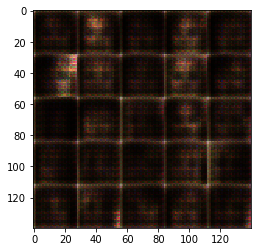

Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 1.1723
Epoch 1/1... Discriminator Loss: 1.5491... Generator Loss: 0.4536
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 1.1139
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.5895... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.5951
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 1.4311
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 1.9928
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 0.9919


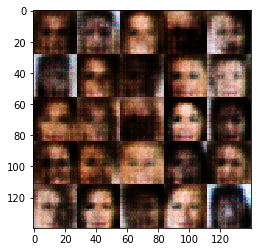

Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 1.4538
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 1.1419
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 1.5602
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 1.5126
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.6509... Generator Loss: 0.4542
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 1.3961
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.9134


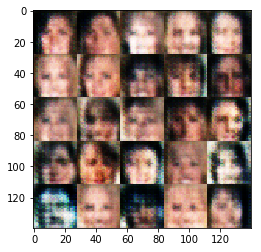

Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 1.0835
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 1.1399
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 1.1438
Epoch 1/1... Discriminator Loss: 1.6100... Generator Loss: 0.4656
Epoch 1/1... Discriminator Loss: 1.6096... Generator Loss: 0.4453
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 1.3110


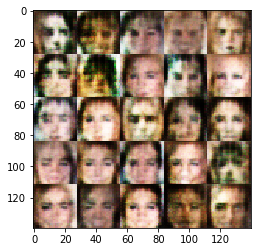

Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 1.2035
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.9735
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.5666
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 1.4253
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.5976
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 1.0777
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 1.2715
Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 1.2556


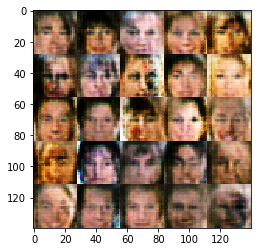

Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 1.2256
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 1.6290
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 1.1868
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.8443


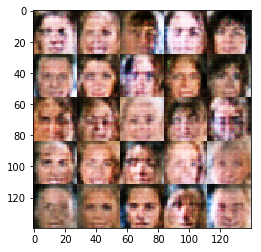

Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 1.1160
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 1.0071
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.9755
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 1.2976
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 1.2824
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 1.1344


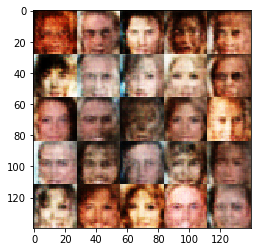

Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 1.2945
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.9240
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 1.1796
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.8332


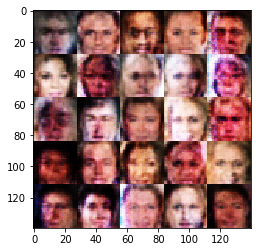

Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 1.1467
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 1.0990
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.5774
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 1.0887
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.6718


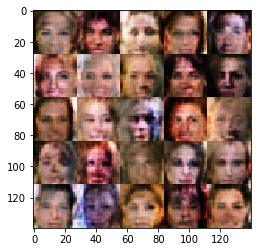

Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 1.0496
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 1.6887
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 1.1663
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.8940
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.9318
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 1.3829


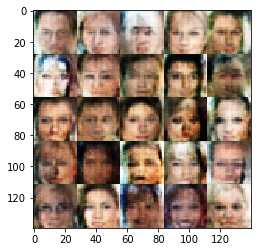

Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 1.5866
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 1.3865
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 1.2527
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 1.1075
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.8553


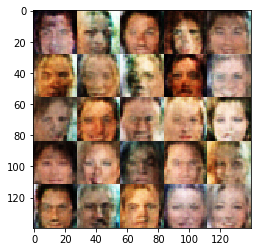

Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 1.2454
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 1.0702
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.9386
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.9579
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 1.2425


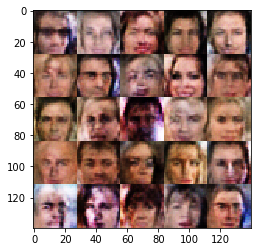

Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 1.0401
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 1.6180
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 1.3572
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 1.2136
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 1.1131
Epoch 1/1... Discriminator Loss: 1.6497... Generator Loss: 0.3925


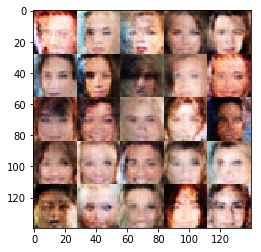

Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.5367
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 1.5988
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 1.0294
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 1.0697


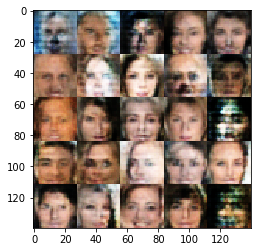

Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 1.4801
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 1.1020
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.9611
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.5686
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 0.9045
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 0.8119


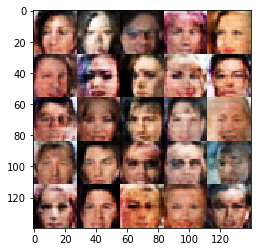

Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 1.1581
Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 1.4083
Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 1.1648
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 1.3227


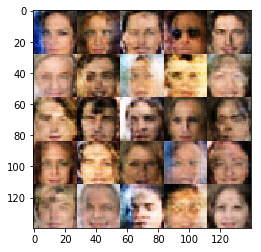

Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.5236
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 1.2532
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 0.9440


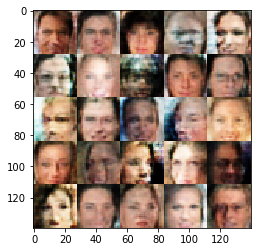

Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 1.1865
Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 0.9961
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 1.0145
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 1.0961
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.5231


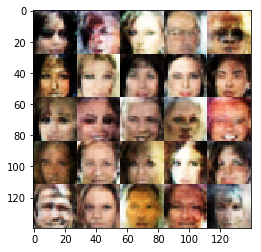

Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 1.2039
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 1.0874
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 1.0604
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 0.9586


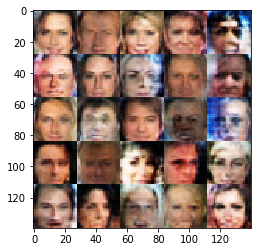

Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 1.4188
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.4467
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.4899
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 1.3742
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 0.9483
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 1.0463


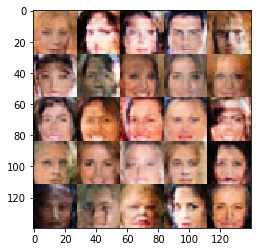

Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 1.1402
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 0.9790
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.8832
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.9516
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 1.0850


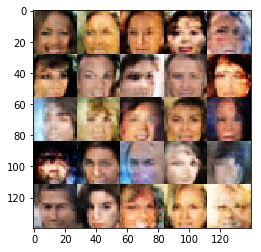

Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 1.3303
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 1.1912
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 1.3238
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 1.1451


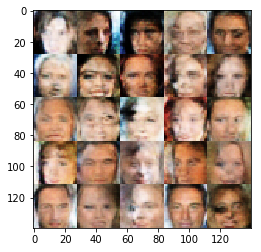

Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 1.2484
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 1.0630
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 1.2268
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.8958
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 1.0219
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.9576
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.9808
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 1.5202
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 1.7633


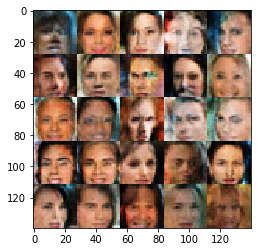

Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 0.9761
Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 1.2907
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 1.1043
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 1.1172
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 1.2208
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.5207
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.6573


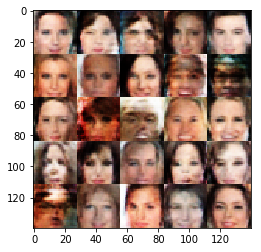

Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 1.1163
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 1.8676
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 1.0122
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 0.9374
Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.9845


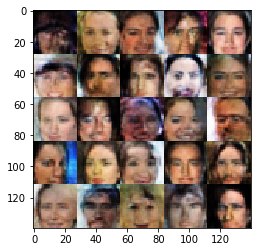

Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 1.2448
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 1.5450
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.9965
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 1.2612
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 1.3153
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.6509


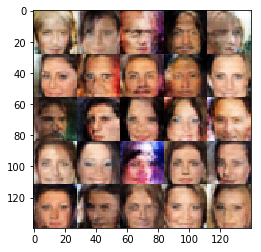

Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 1.2396
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 1.3781
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 1.2161
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.6086


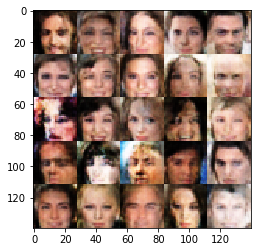

Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 1.1072
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 1.2514
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 1.4292
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 0.9153
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 1.1931
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 1.3358


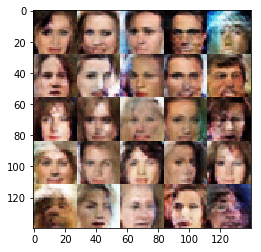

Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.4402
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 0.9859
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 1.1978


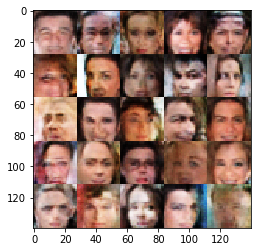

Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 1.6728
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 1.5507
Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 1.0553
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.5748


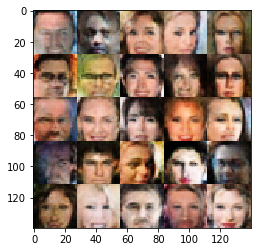

Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 1.3318
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 1.1311
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 1.0616
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 1.4284
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 1.0239
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 1.0736
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 0.9649
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.5750


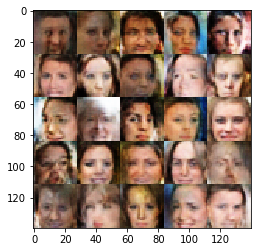

Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 1.0238
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 1.0211
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.5306


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.